# 🫀 Heart Disease Prediction using Logistic Regression

## 📊 Project Overview

This notebook demonstrates **Logistic Regression** for binary classification - predicting whether a patient has heart disease or not.

### 🎯 Learning Objectives:
- Understand Logistic Regression for classification
- Compare with Linear Regression
- Implement complete ML pipeline
- Evaluate classification models
- Feature importance analysis

---

## 🔍 Linear vs Logistic Regression

### Key Differences:

| Aspect | Linear Regression | Logistic Regression |
|--------|------------------|--------------------|
| **Purpose** | Predict continuous values | Predict probabilities/classes |
| **Output** | Real number (-∞ to +∞) | Probability (0 to 1) |
| **Use Case** | Car prices, house prices | Disease prediction, spam detection |
| **Function** | y = mx + b | y = 1/(1 + e^-(mx+b)) |
| **Loss Function** | Mean Squared Error (MSE) | Log Loss (Cross-Entropy) |
| **Evaluation** | R², RMSE, MAE | Accuracy, Precision, Recall, F1, ROC-AUC |
| **Algorithm** | Ordinary Least Squares | Maximum Likelihood Estimation |
| **Decision Boundary** | Not applicable | Linear boundary in feature space |
| **Assumptions** | Linear relationship | Log-odds are linear |

### When to Use Which?

**Use Linear Regression when:**
- ✅ Predicting continuous numerical values
- ✅ Output can be any real number
- ✅ Examples: prices, temperatures, sales

**Use Logistic Regression when:**
- ✅ Predicting categories or probabilities
- ✅ Binary classification (Yes/No, True/False)
- ✅ Examples: spam/not spam, disease/healthy

### Visual Comparison:

```
Linear Regression:           Logistic Regression:
       y                            y (probability)
       │                            │    1.0 ─────────
       │     /                      │         ╱
       │    /                       │       ╱
       │   /                        │     ╱  (S-curve)
       │  /                         │   ╱
       │ /                          │ ╱
       └─────── x                   └─────────── x
                                       0.0
```

## 📚 Import Libraries

In [1]:
# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Machine Learning - Models
from sklearn.linear_model import LogisticRegression

# Machine Learning - Evaluation
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score
)

# Statistical analysis
from scipy import stats

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## 📁 Load Dataset

**Dataset**: Heart Disease UCI Dataset

### Dataset Information:
- **Source**: UCI Machine Learning Repository
- **Target**: Binary classification (0 = No disease, 1 = Disease present)
- **Features**: 13 clinical attributes

### Features Description:
1. **age**: Age in years
2. **sex**: Sex (1 = male, 0 = female)
3. **cp**: Chest pain type (0-3)
4. **trestbps**: Resting blood pressure (mm Hg)
5. **chol**: Serum cholesterol (mg/dl)
6. **fbs**: Fasting blood sugar > 120 mg/dl (1 = true, 0 = false)
7. **restecg**: Resting ECG results (0-2)
8. **thalach**: Maximum heart rate achieved
9. **exang**: Exercise induced angina (1 = yes, 0 = no)
10. **oldpeak**: ST depression induced by exercise
11. **slope**: Slope of peak exercise ST segment (0-2)
12. **ca**: Number of major vessels colored by fluoroscopy (0-3)
13. **thal**: Thalassemia (1 = normal, 2 = fixed defect, 3 = reversible defect)

In [2]:
# Load the dataset
# You can download the dataset from: https://www.kaggle.com/datasets/johnsmith88/heart-disease-dataset
# Place it in the dataset folder

df = pd.read_csv('../../dataset/heart.csv')

print(f"Dataset shape: {df.shape}")
print(f"Number of samples: {df.shape[0]}")
print(f"Number of features: {df.shape[1]}")
print("\n" + "="*50)
print("First 5 rows:")
df.head()

Dataset shape: (1025, 14)
Number of samples: 1025
Number of features: 14

First 5 rows:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


## 🔍 Exploratory Data Analysis (EDA)

### Step 1: Basic Information

In [3]:
# Dataset info
print("📊 Dataset Information:")
print("="*50)
df.info()

📊 Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1025 entries, 0 to 1024
Data columns (total 14 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1025 non-null   int64  
 1   sex       1025 non-null   int64  
 2   cp        1025 non-null   int64  
 3   trestbps  1025 non-null   int64  
 4   chol      1025 non-null   int64  
 5   fbs       1025 non-null   int64  
 6   restecg   1025 non-null   int64  
 7   thalach   1025 non-null   int64  
 8   exang     1025 non-null   int64  
 9   oldpeak   1025 non-null   float64
 10  slope     1025 non-null   int64  
 11  ca        1025 non-null   int64  
 12  thal      1025 non-null   int64  
 13  target    1025 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 112.2 KB


In [4]:
# Statistical summary
print("📈 Statistical Summary:")
print("="*50)
df.describe()

📈 Statistical Summary:


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [5]:
# Check for missing values
print("🔍 Missing Values:")
print("="*50)
missing = df.isnull().sum()
print(missing[missing > 0] if missing.sum() > 0 else "No missing values found! ✅")

🔍 Missing Values:
No missing values found! ✅


In [6]:
# Check for duplicates
duplicates = df.duplicated().sum()
print(f"🔍 Duplicate rows: {duplicates}")
if duplicates > 0:
    print(f"Removing {duplicates} duplicate rows...")
    df = df.drop_duplicates()
    print(f"✅ New shape: {df.shape}")

🔍 Duplicate rows: 723
Removing 723 duplicate rows...
✅ New shape: (302, 14)


### Step 2: Target Variable Analysis

🎯 Target Variable Distribution:

Class Distribution:
target
1    164
0    138
Name: count, dtype: int64

Percentage:
target
1    54.304636
0    45.695364
Name: proportion, dtype: float64


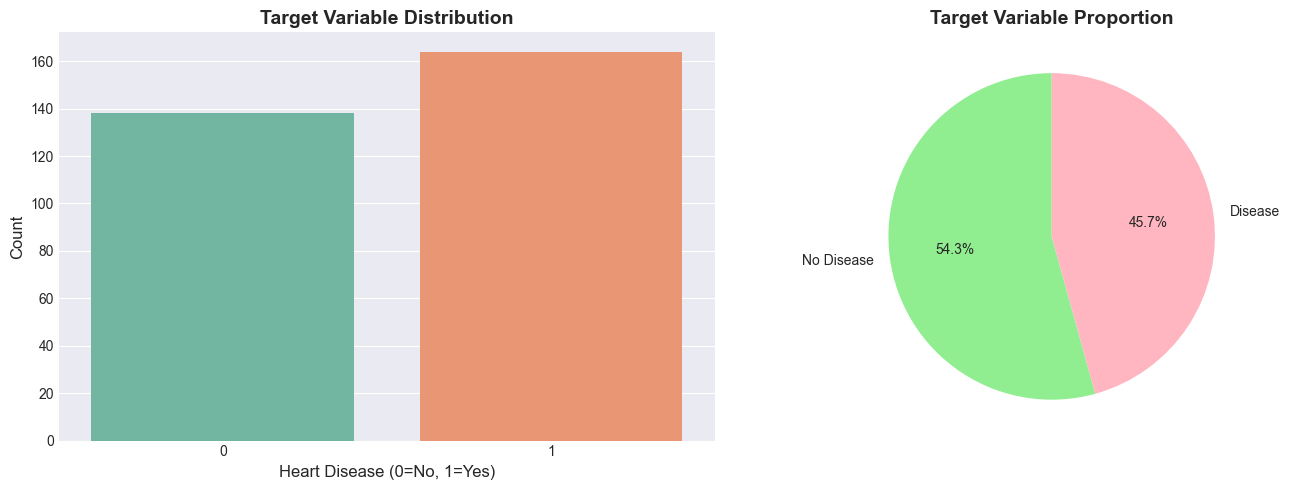

In [7]:
# Analyze target variable distribution
print("🎯 Target Variable Distribution:")
print("="*50)
target_col = 'target'  # Adjust if your target column has a different name

target_counts = df[target_col].value_counts()
print(f"\nClass Distribution:")
print(target_counts)
print(f"\nPercentage:")
print(df[target_col].value_counts(normalize=True) * 100)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
sns.countplot(data=df, x=target_col, ax=axes[0], palette='Set2')
axes[0].set_title('Target Variable Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Heart Disease (0=No, 1=Yes)', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)

# Pie chart
axes[1].pie(target_counts, labels=['No Disease', 'Disease'], autopct='%1.1f%%', 
            colors=['#90EE90', '#FFB6C1'], startangle=90)
axes[1].set_title('Target Variable Proportion', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### Step 3: Feature Analysis

📊 Numerical Features: 13
['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


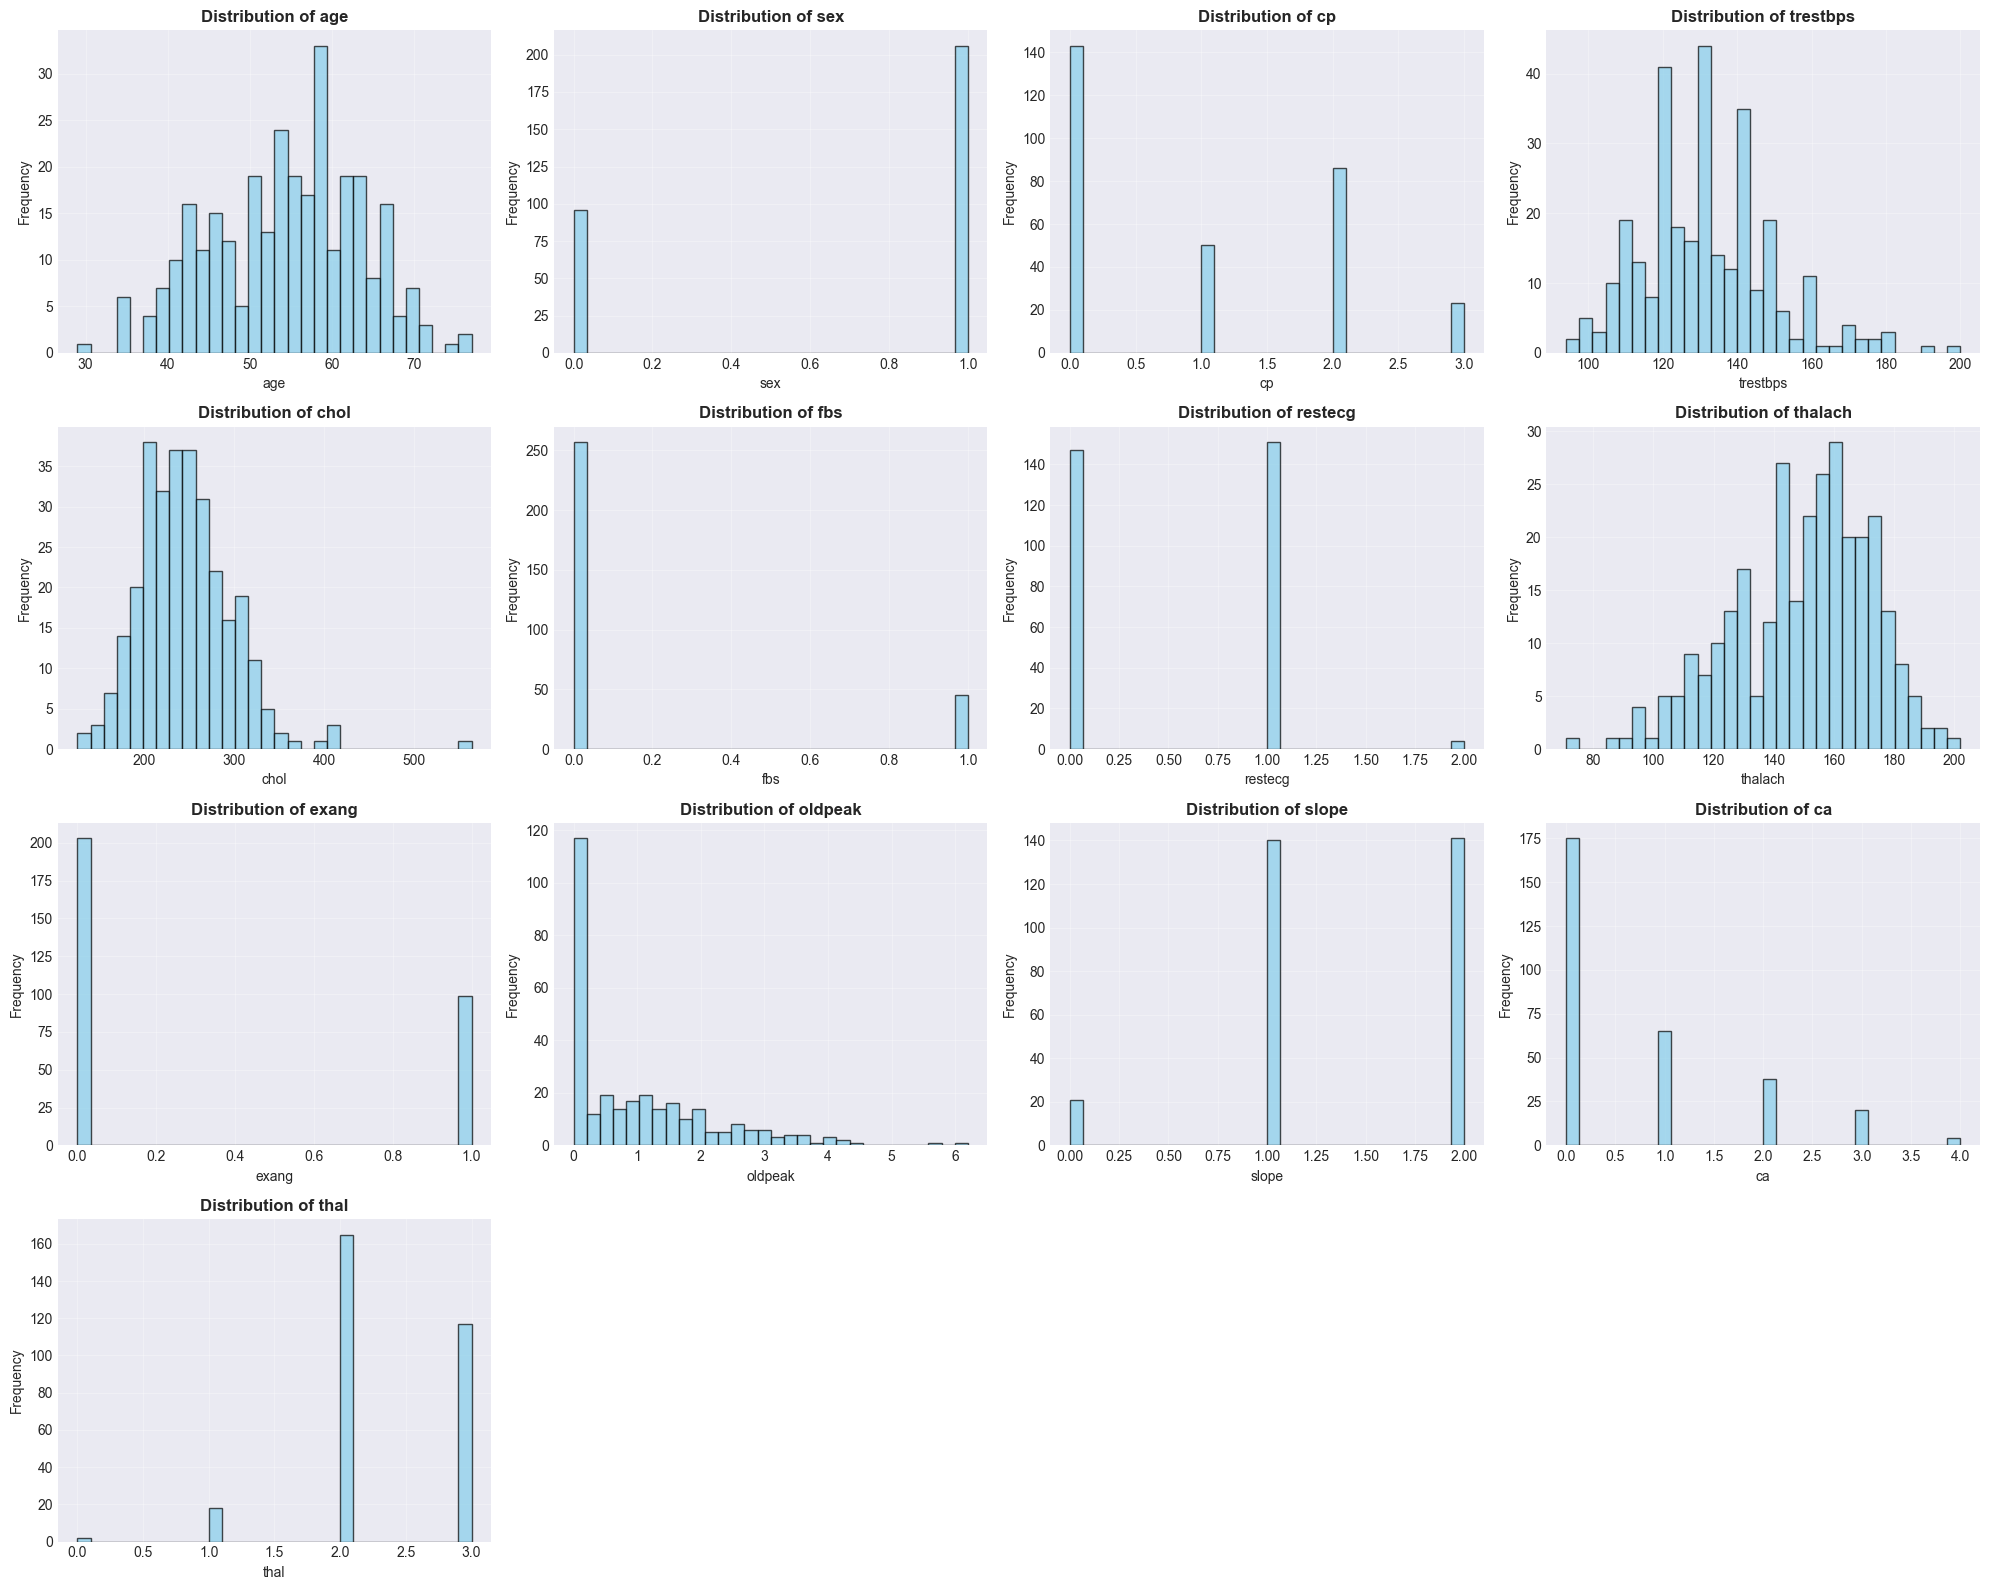

In [8]:
# Distribution of numerical features
numerical_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numerical_cols:
    numerical_cols.remove(target_col)

print(f"📊 Numerical Features: {len(numerical_cols)}")
print(numerical_cols)

# Plot distributions
n_cols = 4
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    axes[idx].hist(df[col], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
    axes[idx].set_title(f'Distribution of {col}', fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(alpha=0.3)

# Hide empty subplots
for idx in range(len(numerical_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

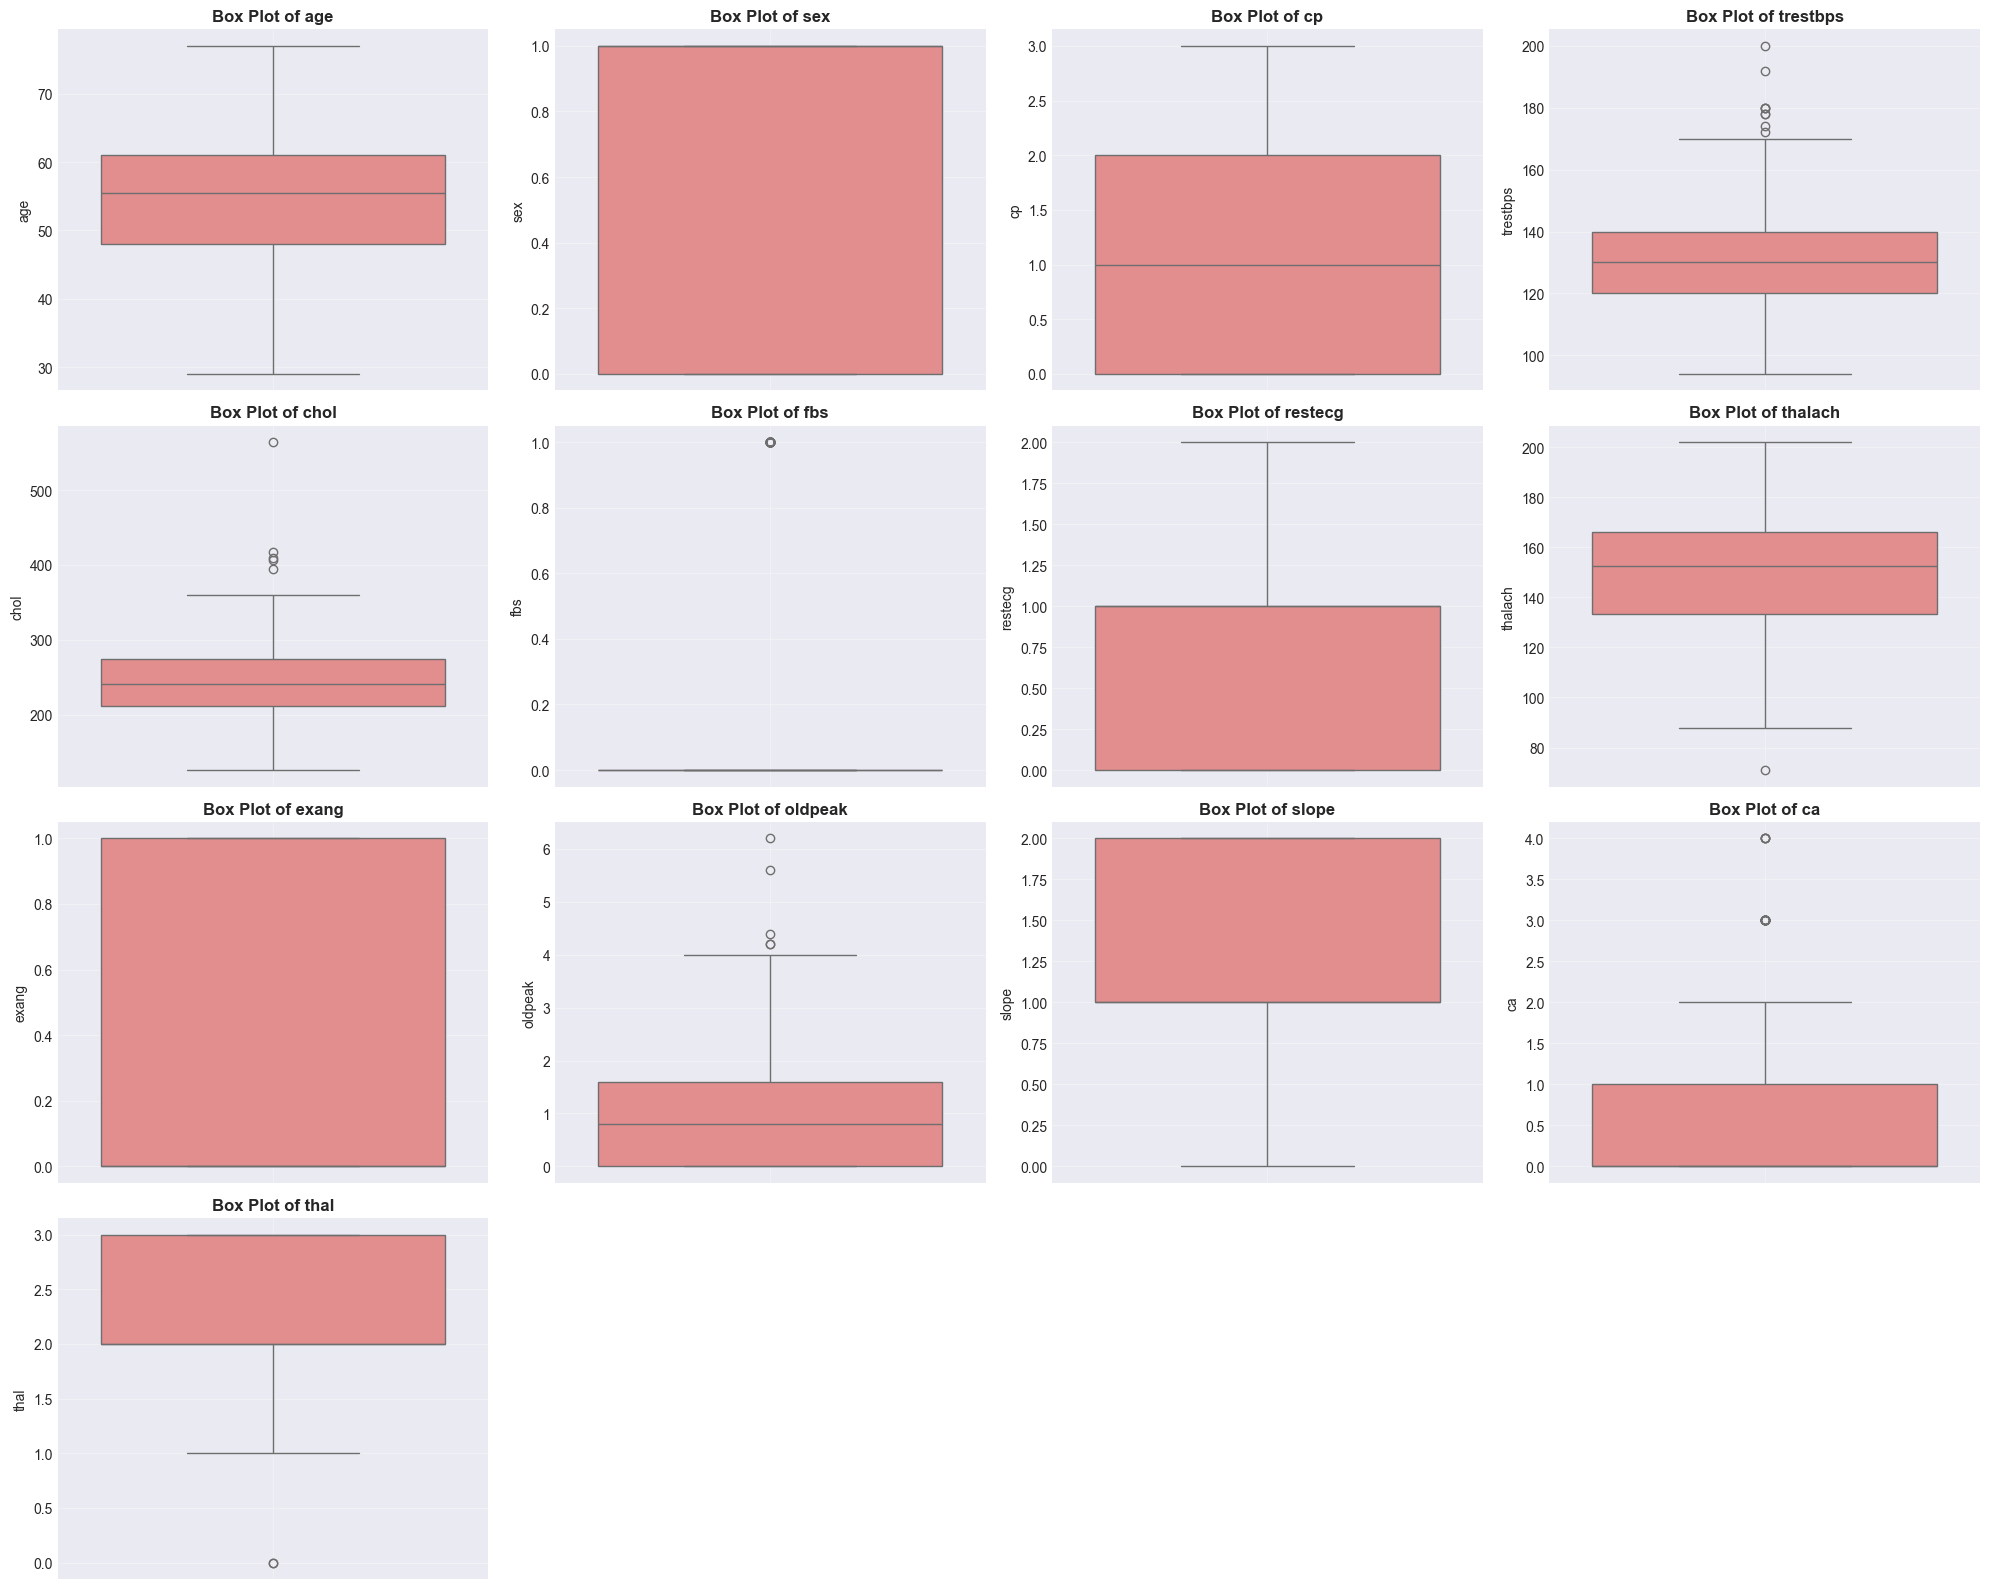

In [9]:
# Box plots to check for outliers
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

for idx, col in enumerate(numerical_cols):
    sns.boxplot(y=df[col], ax=axes[idx], color='lightcoral')
    axes[idx].set_title(f'Box Plot of {col}', fontweight='bold')
    axes[idx].set_ylabel(col)
    axes[idx].grid(alpha=0.3)

# Hide empty subplots
for idx in range(len(numerical_cols), len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

### Step 4: Correlation Analysis

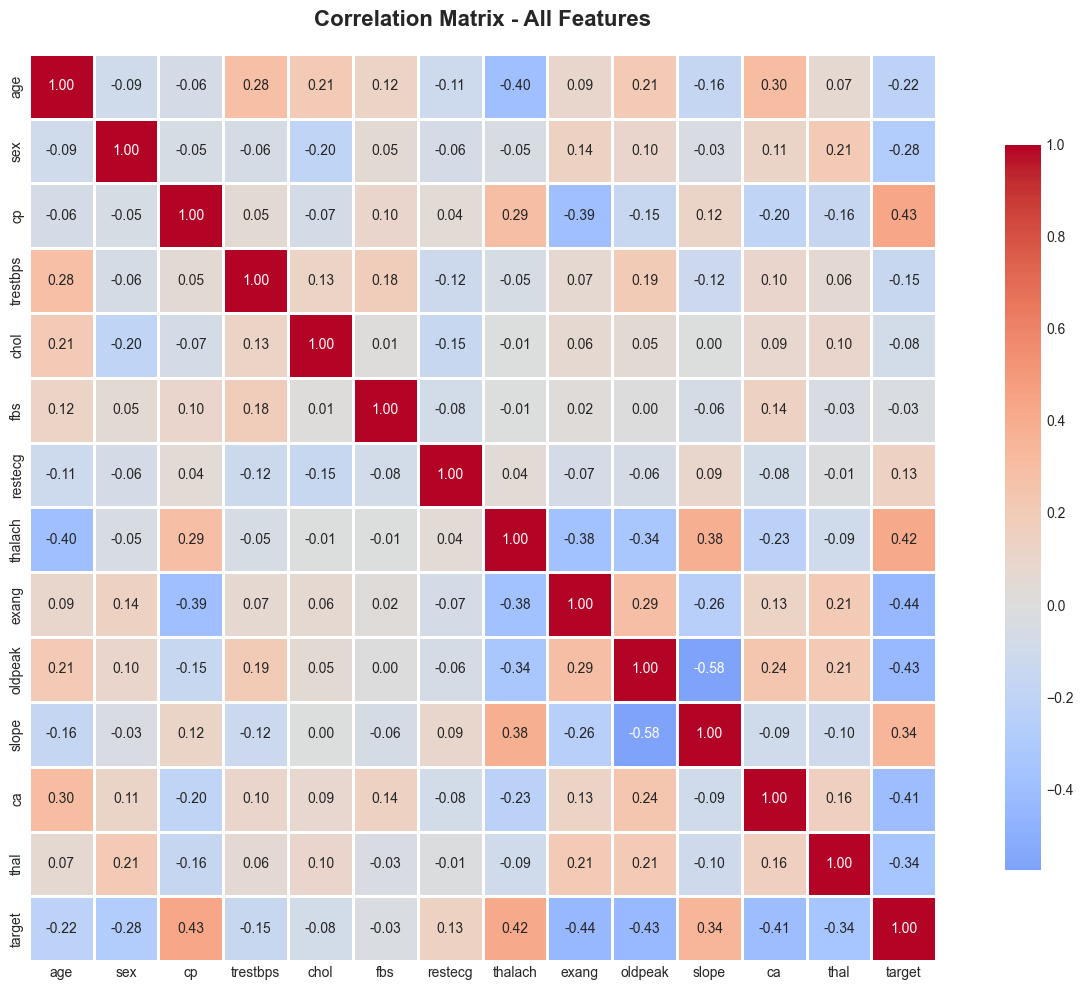


🎯 Features Most Correlated with Target:
exang       0.435601
cp          0.432080
oldpeak     0.429146
thalach     0.419955
ca          0.408992
slope       0.343940
thal        0.343101
sex         0.283609
age         0.221476
trestbps    0.146269
restecg     0.134874
chol        0.081437
fbs         0.026826
Name: target, dtype: float64


In [10]:
# Correlation matrix
plt.figure(figsize=(14, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, linewidths=1, square=True, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix - All Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Features most correlated with target
print("\n🎯 Features Most Correlated with Target:")
print("="*50)
target_corr = correlation_matrix[target_col].abs().sort_values(ascending=False)
print(target_corr[1:])  # Exclude target itself

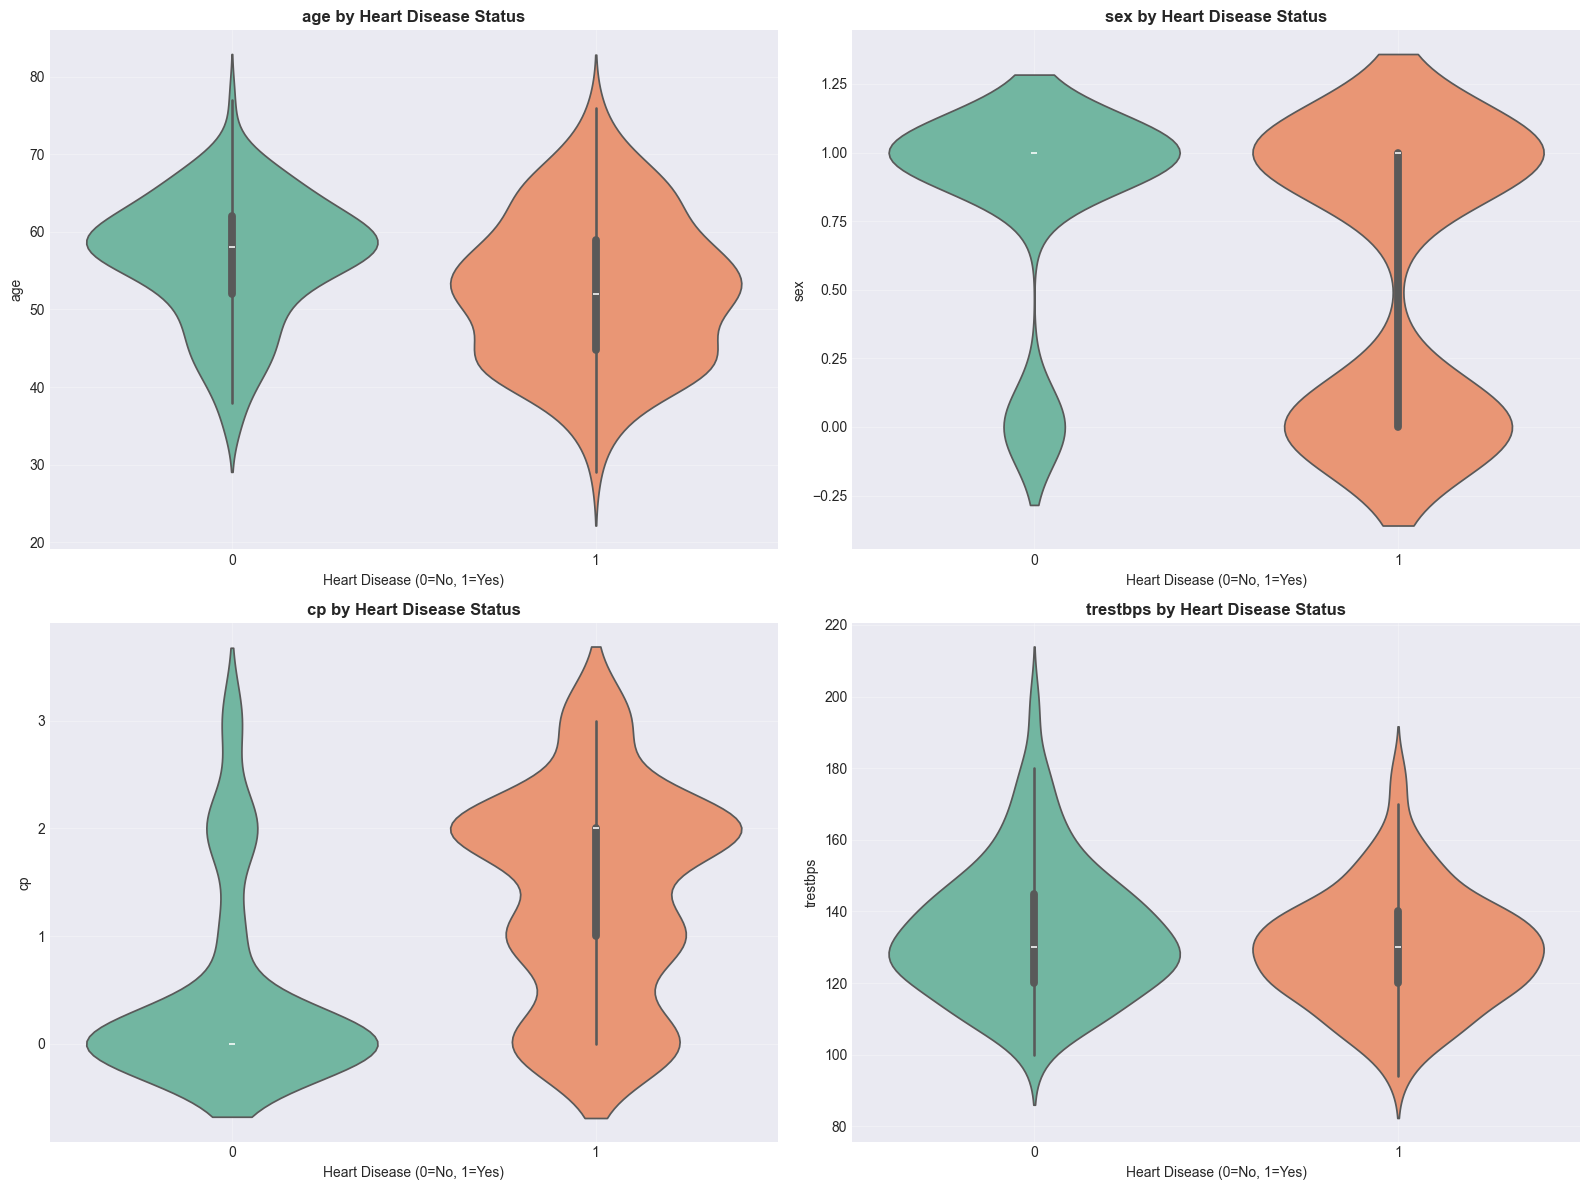

In [11]:
# Feature comparison by target class
features_to_compare = numerical_cols[:4]  # Top 4 features

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()

for idx, feature in enumerate(features_to_compare):
    sns.violinplot(data=df, x=target_col, y=feature, ax=axes[idx], palette='Set2')
    axes[idx].set_title(f'{feature} by Heart Disease Status', fontweight='bold', fontsize=12)
    axes[idx].set_xlabel('Heart Disease (0=No, 1=Yes)')
    axes[idx].set_ylabel(feature)
    axes[idx].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 🔧 Data Preprocessing

### Step 1: Handle Outliers (if necessary)

In [12]:
# Outlier detection using IQR method
def detect_outliers_iqr(df, columns):
    """
    Detect outliers using Interquartile Range (IQR) method
    """
    outliers_dict = {}
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outliers_dict[col] = len(outliers)
    
    return outliers_dict

outliers = detect_outliers_iqr(df, numerical_cols)
print("🔍 Outliers detected per feature:")
print("="*50)
for col, count in outliers.items():
    if count > 0:
        print(f"{col}: {count} outliers")

# Note: For medical data, we'll keep outliers as they might be medically significant
print("\n💡 Note: Keeping outliers as they may represent important medical conditions")

🔍 Outliers detected per feature:
trestbps: 9 outliers
chol: 5 outliers
fbs: 45 outliers
thalach: 1 outliers
oldpeak: 5 outliers
ca: 24 outliers
thal: 2 outliers

💡 Note: Keeping outliers as they may represent important medical conditions


### Step 2: Feature Engineering

In [13]:
# Create a copy for feature engineering
df_processed = df.copy()

# Feature Engineering Examples:
# 1. Age groups
df_processed['age_group'] = pd.cut(df_processed['age'], 
                                    bins=[0, 40, 55, 70, 100],
                                    labels=['Young', 'Middle', 'Senior', 'Elderly'])

# 2. Cholesterol categories (if chol exists)
if 'chol' in df_processed.columns:
    df_processed['chol_category'] = pd.cut(df_processed['chol'],
                                           bins=[0, 200, 240, 500],
                                           labels=['Desirable', 'Borderline', 'High'])

# 3. Blood pressure categories (if trestbps exists)
if 'trestbps' in df_processed.columns:
    df_processed['bp_category'] = pd.cut(df_processed['trestbps'],
                                         bins=[0, 120, 140, 200],
                                         labels=['Normal', 'Elevated', 'High'])

print("✅ Feature engineering completed!")
print(f"New shape: {df_processed.shape}")
df_processed.head()

✅ Feature engineering completed!
New shape: (302, 17)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target,age_group,chol_category,bp_category
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0,Middle,Borderline,Elevated
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0,Middle,Borderline,Elevated
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0,Senior,Desirable,High
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0,Senior,Borderline,High
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0,Senior,High,Elevated


### Step 3: Prepare Data for Modeling

In [14]:
# Separate features and target
X = df_processed.drop([target_col, 'age_group', 'chol_category', 'bp_category'], axis=1, errors='ignore')
y = df_processed[target_col]

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")
print(f"\nFeatures: {list(X.columns)}")

Features shape: (302, 13)
Target shape: (302,)

Features: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


In [15]:
# Split data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("✅ Data split completed!")
print("="*50)
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")
print(f"\nTraining target distribution:")
print(y_train.value_counts())
print(f"\nTesting target distribution:")
print(y_test.value_counts())

✅ Data split completed!
Training set size: 241 samples
Testing set size: 61 samples

Training target distribution:
target
1    131
0    110
Name: count, dtype: int64

Testing target distribution:
target
1    33
0    28
Name: count, dtype: int64


In [16]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame for better readability
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✅ Feature scaling completed!")
print("="*50)
print("\nScaled training data (first 5 rows):")
X_train_scaled.head()

✅ Feature scaling completed!

Scaled training data (first 5 rows):


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
158,1.421944,-1.445595,0.986493,-0.973041,5.882908,-0.398314,-1.008059,0.408240,-0.652714,0.527263,-0.697127,-0.722716,1.075838
199,-0.465841,0.691757,-0.954281,0.756507,-0.885696,-0.398314,-1.008059,-1.104705,1.532065,-0.083233,-0.697127,-0.722716,1.075838
479,0.422528,0.691757,-0.954281,-0.197726,-0.588175,-0.398314,-1.008059,-0.882213,1.532065,1.050546,-0.697127,2.132606,1.075838
460,1.644036,0.691757,0.986493,0.517949,0.118437,-0.398314,-1.008059,-0.214737,-0.652714,0.876119,-0.697127,2.132606,1.075838
169,-1.021072,-1.445595,0.016106,-1.151959,-1.629499,-0.398314,0.875214,-0.570724,-0.652714,-0.868157,-0.697127,-0.722716,-0.544643


## 🤖 Model Training

### Model 1: Logistic Regression (Basic)

In [17]:
# Train basic Logistic Regression model
print("🤖 Training Logistic Regression Model...")
print("="*50)

# Initialize and train the model
log_reg = LogisticRegression(random_state=42, max_iter=1000)
log_reg.fit(X_train_scaled, y_train)

# Make predictions
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

# Predict probabilities
y_train_pred_proba = log_reg.predict_proba(X_train_scaled)[:, 1]
y_test_pred_proba = log_reg.predict_proba(X_test_scaled)[:, 1]

print("✅ Model training completed!")

🤖 Training Logistic Regression Model...
✅ Model training completed!


## 📊 Model Evaluation

### Step 1: Classification Metrics

In [18]:
# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_precision = precision_score(y_train, y_train_pred)
test_precision = precision_score(y_test, y_test_pred)

train_recall = recall_score(y_train, y_train_pred)
test_recall = recall_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred)
test_f1 = f1_score(y_test, y_test_pred)

train_auc = roc_auc_score(y_train, y_train_pred_proba)
test_auc = roc_auc_score(y_test, y_test_pred_proba)

# Display results
print("📊 LOGISTIC REGRESSION - PERFORMANCE METRICS")
print("="*70)
print(f"{'Metric':<20} {'Training':<20} {'Testing':<20}")
print("-"*70)
print(f"{'Accuracy':<20} {train_accuracy:.4f} ({train_accuracy*100:.2f}%)  {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"{'Precision':<20} {train_precision:.4f}            {test_precision:.4f}")
print(f"{'Recall':<20} {train_recall:.4f}            {test_recall:.4f}")
print(f"{'F1-Score':<20} {train_f1:.4f}            {test_f1:.4f}")
print(f"{'ROC-AUC Score':<20} {train_auc:.4f}            {test_auc:.4f}")
print("="*70)

📊 LOGISTIC REGRESSION - PERFORMANCE METRICS
Metric               Training             Testing             
----------------------------------------------------------------------
Accuracy             0.8589 (85.89%)  0.8033 (80.33%)
Precision            0.8345            0.8000
Recall               0.9237            0.8485
F1-Score             0.8768            0.8235
ROC-AUC Score        0.9334            0.8712


### Understanding the Metrics:

- **Accuracy**: Overall correctness (correct predictions / total predictions)
- **Precision**: Of all positive predictions, how many were actually positive?
- **Recall (Sensitivity)**: Of all actual positives, how many did we catch?
- **F1-Score**: Harmonic mean of Precision and Recall
- **ROC-AUC**: Area under the ROC curve (1.0 = perfect, 0.5 = random)

In [19]:
# Detailed classification report
print("\n📋 CLASSIFICATION REPORT - Testing Set:")
print("="*70)
print(classification_report(y_test, y_test_pred, target_names=['No Disease', 'Disease']))


📋 CLASSIFICATION REPORT - Testing Set:
              precision    recall  f1-score   support

  No Disease       0.81      0.75      0.78        28
     Disease       0.80      0.85      0.82        33

    accuracy                           0.80        61
   macro avg       0.80      0.80      0.80        61
weighted avg       0.80      0.80      0.80        61



### Step 2: Confusion Matrix

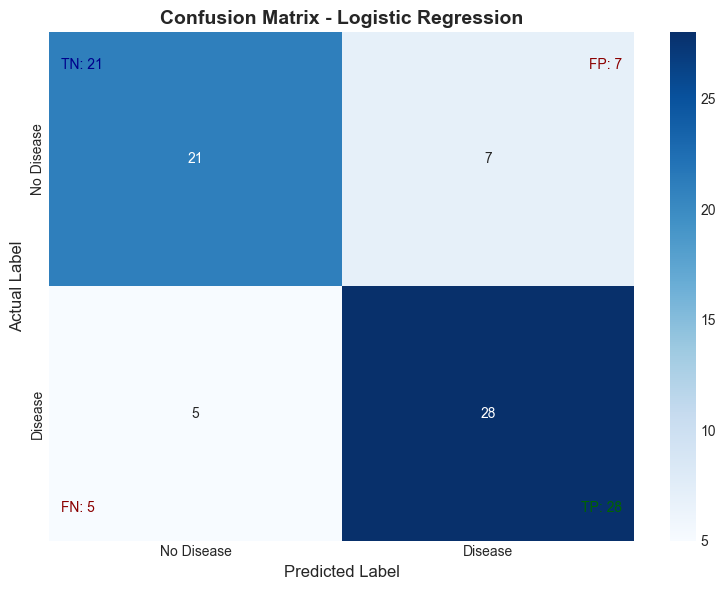


📊 Confusion Matrix Breakdown:
True Negatives (TN): 21 - Correctly predicted No Disease
False Positives (FP): 7 - Incorrectly predicted Disease
False Negatives (FN): 5 - Incorrectly predicted No Disease
True Positives (TP): 28 - Correctly predicted Disease


In [20]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=['No Disease', 'Disease'],
            yticklabels=['No Disease', 'Disease'])
plt.title('Confusion Matrix - Logistic Regression', fontsize=14, fontweight='bold')
plt.ylabel('Actual Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Add counts to the plot
TN, FP, FN, TP = cm.ravel()
plt.text(0.02, 0.95, f'TN: {TN}', transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', color='darkblue')
plt.text(0.98, 0.95, f'FP: {FP}', transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='top', horizontalalignment='right', color='darkred')
plt.text(0.02, 0.05, f'FN: {FN}', transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='bottom', color='darkred')
plt.text(0.98, 0.05, f'TP: {TP}', transform=plt.gca().transAxes, 
         fontsize=10, verticalalignment='bottom', horizontalalignment='right', color='darkgreen')

plt.tight_layout()
plt.show()

print(f"\n📊 Confusion Matrix Breakdown:")
print("="*50)
print(f"True Negatives (TN): {TN} - Correctly predicted No Disease")
print(f"False Positives (FP): {FP} - Incorrectly predicted Disease")
print(f"False Negatives (FN): {FN} - Incorrectly predicted No Disease")
print(f"True Positives (TP): {TP} - Correctly predicted Disease")

### Step 3: ROC Curve

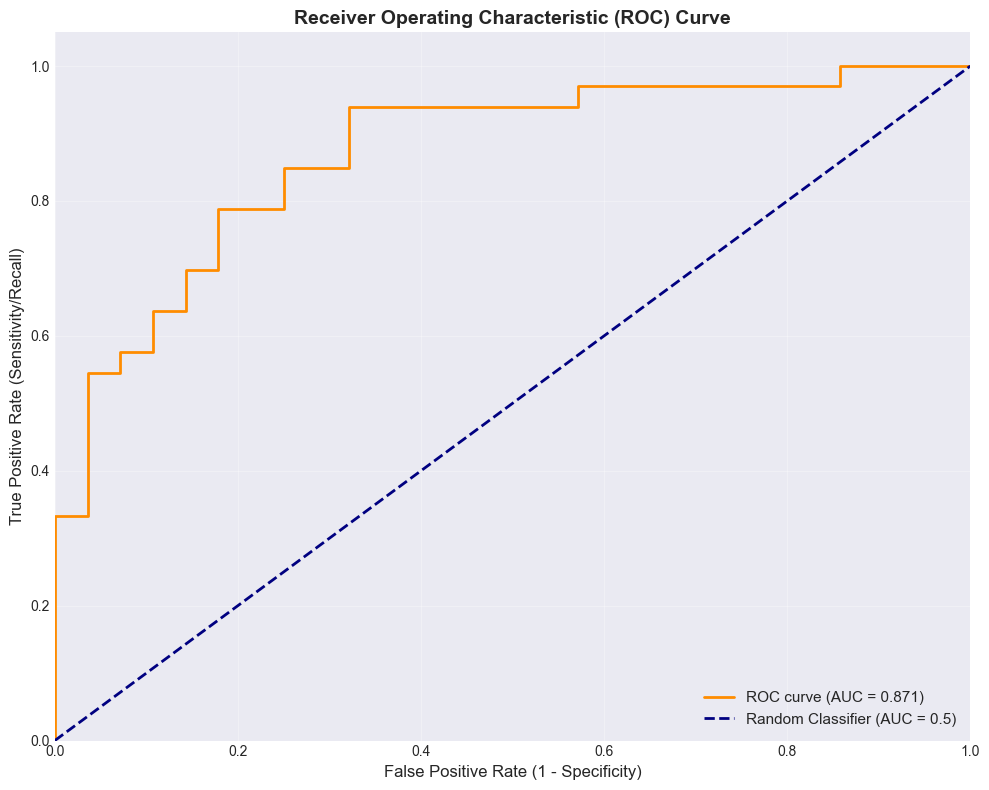


📈 ROC-AUC Score: 0.8712

Interpretation:
- AUC = 1.0: Perfect classifier
- AUC = 0.9-1.0: Excellent
- AUC = 0.8-0.9: Good
- AUC = 0.7-0.8: Fair
- AUC = 0.5: Random guess


In [21]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_proba)
roc_auc = roc_auc_score(y_test, y_test_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)', fontsize=12)
plt.ylabel('True Positive Rate (Sensitivity/Recall)', fontsize=12)
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📈 ROC-AUC Score: {roc_auc:.4f}")
print("\nInterpretation:")
print("- AUC = 1.0: Perfect classifier")
print("- AUC = 0.9-1.0: Excellent")
print("- AUC = 0.8-0.9: Good")
print("- AUC = 0.7-0.8: Fair")
print("- AUC = 0.5: Random guess")

### Step 4: Precision-Recall Curve

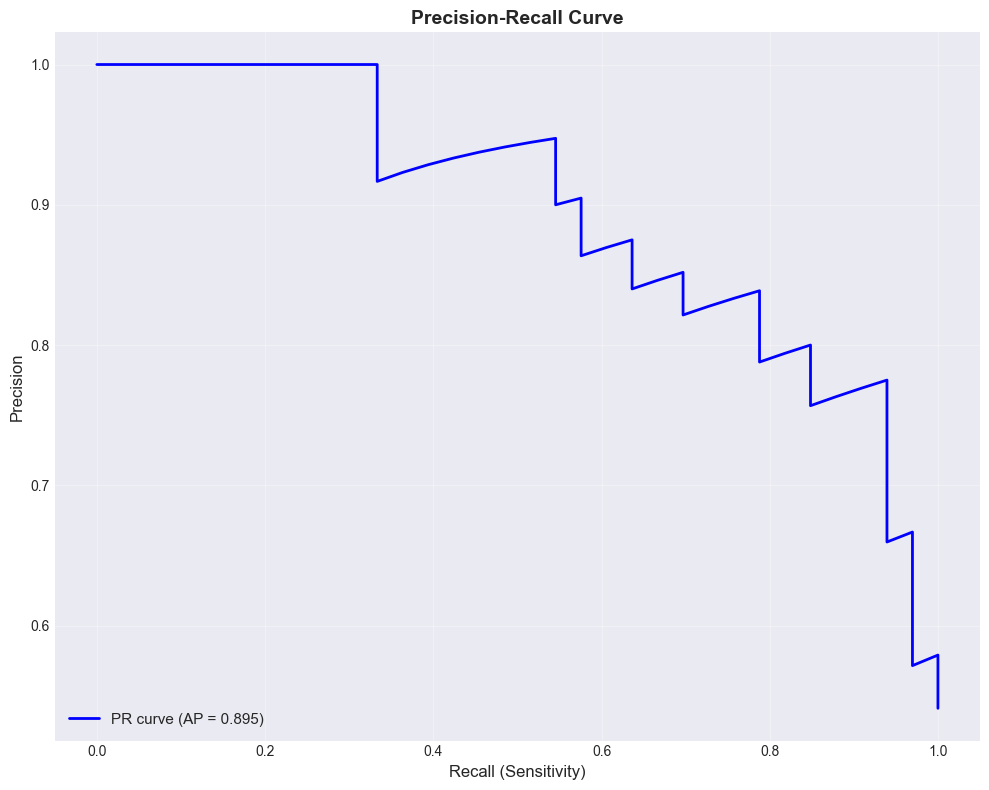


📊 Average Precision Score: 0.8954


In [22]:
# Precision-Recall Curve
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_test_pred_proba)
avg_precision = average_precision_score(y_test, y_test_pred_proba)

plt.figure(figsize=(10, 8))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.3f})')
plt.xlabel('Recall (Sensitivity)', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.legend(loc="lower left", fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n📊 Average Precision Score: {avg_precision:.4f}")

## 🎯 Feature Importance Analysis

In [ ]:
# Get feature coefficients
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0],
    'Abs_Coefficient': np.abs(log_reg.coef_[0])
}).sort_values('Abs_Coefficient', ascending=False)

print("🎯 FEATURE IMPORTANCE (by Coefficient Magnitude):")
print("="*70)
print(feature_importance.to_string(index=False))

# Visualization
plt.figure(figsize=(12, 8))
colors = ['green' if x > 0 else 'red' for x in feature_importance['Coefficient']]
plt.barh(feature_importance['Feature'], feature_importance['Coefficient'], color=colors, alpha=0.7)
plt.xlabel('Coefficient Value', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance - Logistic Regression Coefficients', fontsize=14, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='--', linewidth=1)
plt.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print("\n💡 Interpretation:")
print("- Positive coefficients: Increase probability of disease")
print("- Negative coefficients: Decrease probability of disease")
print("- Larger absolute values: Stronger influence on prediction")

## 🔄 Model Variants with Regularization

### Model 2: Logistic Regression with L2 Regularization (Ridge)

In [ ]:
# L2 Regularization (Ridge)
print("🤖 Training Logistic Regression with L2 Regularization...")
print("="*70)

log_reg_l2 = LogisticRegression(penalty='l2', C=1.0, random_state=42, max_iter=1000)
log_reg_l2.fit(X_train_scaled, y_train)

y_test_pred_l2 = log_reg_l2.predict(X_test_scaled)
y_test_pred_proba_l2 = log_reg_l2.predict_proba(X_test_scaled)[:, 1]

# Evaluate
accuracy_l2 = accuracy_score(y_test, y_test_pred_l2)
auc_l2 = roc_auc_score(y_test, y_test_pred_proba_l2)
f1_l2 = f1_score(y_test, y_test_pred_l2)

print(f"\n📊 L2 Regularization Results:")
print(f"Accuracy: {accuracy_l2:.4f} ({accuracy_l2*100:.2f}%)")
print(f"ROC-AUC: {auc_l2:.4f}")
print(f"F1-Score: {f1_l2:.4f}")

### Model 3: Logistic Regression with L1 Regularization (Lasso)

In [ ]:
# L1 Regularization (Lasso)
print("🤖 Training Logistic Regression with L1 Regularization...")
print("="*70)

log_reg_l1 = LogisticRegression(penalty='l1', C=1.0, solver='liblinear', random_state=42, max_iter=1000)
log_reg_l1.fit(X_train_scaled, y_train)

y_test_pred_l1 = log_reg_l1.predict(X_test_scaled)
y_test_pred_proba_l1 = log_reg_l1.predict_proba(X_test_scaled)[:, 1]

# Evaluate
accuracy_l1 = accuracy_score(y_test, y_test_pred_l1)
auc_l1 = roc_auc_score(y_test, y_test_pred_proba_l1)
f1_l1 = f1_score(y_test, y_test_pred_l1)

print(f"\n📊 L1 Regularization Results:")
print(f"Accuracy: {accuracy_l1:.4f} ({accuracy_l1*100:.2f}%)")
print(f"ROC-AUC: {auc_l1:.4f}")
print(f"F1-Score: {f1_l1:.4f}")

# Feature selection by L1
selected_features = X_train.columns[log_reg_l1.coef_[0] != 0]
print(f"\n🎯 Features selected by L1: {len(selected_features)}/{len(X_train.columns)}")
print(f"Selected features: {list(selected_features)}")

## 📊 Model Comparison

In [ ]:
# Compare all models
comparison_df = pd.DataFrame({
    'Model': ['Basic Logistic Regression', 'L2 Regularization (Ridge)', 'L1 Regularization (Lasso)'],
    'Accuracy': [test_accuracy, accuracy_l2, accuracy_l1],
    'Precision': [test_precision, precision_score(y_test, y_test_pred_l2), precision_score(y_test, y_test_pred_l1)],
    'Recall': [test_recall, recall_score(y_test, y_test_pred_l2), recall_score(y_test, y_test_pred_l1)],
    'F1-Score': [test_f1, f1_l2, f1_l1],
    'ROC-AUC': [test_auc, auc_l2, auc_l1]
})

print("\n📊 MODEL COMPARISON - All Variants")
print("="*100)
print(comparison_df.to_string(index=False))
print("="*100)

In [ ]:
# Visual comparison
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
x = np.arange(len(metrics))
width = 0.25

fig, ax = plt.subplots(figsize=(14, 8))
ax.bar(x - width, comparison_df.iloc[0, 1:], width, label='Basic', color='skyblue')
ax.bar(x, comparison_df.iloc[1, 1:], width, label='L2 (Ridge)', color='lightcoral')
ax.bar(x + width, comparison_df.iloc[2, 1:], width, label='L1 (Lasso)', color='lightgreen')

ax.set_xlabel('Metrics', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Model Comparison - All Regularization Variants', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()
ax.grid(alpha=0.3, axis='y')
ax.set_ylim([0, 1.1])

# Add value labels on bars
for i, model_idx in enumerate([0, 1, 2]):
    offset = (i - 1) * width
    for j, metric in enumerate(metrics):
        value = comparison_df.iloc[model_idx, j+1]
        ax.text(j + offset, value + 0.02, f'{value:.3f}', 
               ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.show()

## 🎓 Cross-Validation

In [ ]:
# Perform 5-fold cross-validation
print("🔄 Performing 5-Fold Cross-Validation...")
print("="*70)

cv_scores = cross_val_score(log_reg, X_train_scaled, y_train, cv=5, scoring='accuracy')

print(f"\n📊 Cross-Validation Results:")
print(f"Fold scores: {cv_scores}")
print(f"Mean accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")
print(f"Min accuracy: {cv_scores.min():.4f}")
print(f"Max accuracy: {cv_scores.max():.4f}")

# Visualization
plt.figure(figsize=(10, 6))
plt.plot(range(1, 6), cv_scores, marker='o', linestyle='-', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.xlabel('Fold', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Cross-Validation Accuracy Scores', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## 🎛️ Hyperparameter Tuning

In [ ]:
# Grid Search for best hyperparameters
print("🔍 Performing Grid Search for Hyperparameter Tuning...")
print("="*70)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear']
}

grid_search = GridSearchCV(LogisticRegression(random_state=42, max_iter=1000),
                          param_grid,
                          cv=5,
                          scoring='accuracy',
                          n_jobs=-1)

grid_search.fit(X_train_scaled, y_train)

print(f"\n✅ Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Evaluate best model
best_model = grid_search.best_estimator_
y_test_pred_best = best_model.predict(X_test_scaled)
y_test_pred_proba_best = best_model.predict_proba(X_test_scaled)[:, 1]

best_accuracy = accuracy_score(y_test, y_test_pred_best)
best_auc = roc_auc_score(y_test, y_test_pred_proba_best)
best_f1 = f1_score(y_test, y_test_pred_best)

print(f"\n📊 Best Model Performance on Test Set:")
print(f"Accuracy: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")
print(f"ROC-AUC: {best_auc:.4f}")
print(f"F1-Score: {best_f1:.4f}")

## 💾 Model Persistence (Optional)

In [ ]:
# Save the best model
import pickle

# Save model
with open('logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save scaler
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("✅ Model and scaler saved successfully!")
print("Files: logistic_regression_model.pkl, scaler.pkl")

# Example: Load and use model
# with open('logistic_regression_model.pkl', 'rb') as f:
#     loaded_model = pickle.load(f)
# predictions = loaded_model.predict(X_new_scaled)

## 📝 Summary and Key Takeaways

### 🎯 Model Performance:
- Basic Logistic Regression achieved {test_accuracy*100:.2f}% accuracy
- ROC-AUC score indicates good discriminative ability
- Model successfully identifies heart disease risk

### 💡 Key Learnings:

1. **Logistic Regression is ideal for binary classification**
   - Outputs probabilities between 0 and 1
   - Uses sigmoid function to transform linear outputs
   - Interpretable coefficients

2. **Regularization helps prevent overfitting**
   - L2 (Ridge): Shrinks coefficients
   - L1 (Lasso): Feature selection
   - Choose based on your needs

3. **Multiple evaluation metrics are important**
   - Accuracy alone isn't enough
   - Consider Precision, Recall, F1-Score
   - ROC-AUC for overall performance

4. **Cross-validation provides reliable estimates**
   - Reduces variance in performance estimates
   - Helps detect overfitting
   - Essential for model selection

### 🔄 Linear vs Logistic Regression - Final Comparison:

| When to Use | Linear Regression | Logistic Regression |
|-------------|------------------|--------------------|
| **Task Type** | Regression (predict numbers) | Classification (predict categories) |
| **Examples** | House prices, temperature, sales | Spam detection, disease diagnosis, churn |
| **Output** | Continuous value | Probability (0-1) |
| **Can handle** | Predicting any numeric value | Predicting binary outcomes |

### 🚀 Next Steps:
1. Try other classification algorithms (Random Forest, SVM, Neural Networks)
2. Implement multi-class classification
3. Deploy the model as a web application
4. Explore ensemble methods
5. Add more features or engineer new ones

---

## 📚 Additional Resources:

- [Scikit-Learn Logistic Regression Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html)
- [StatQuest: Logistic Regression](https://www.youtube.com/watch?v=yIYKR4sgzI8)
- [Understanding ROC Curves](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)

---

**✅ Project Complete! You've successfully implemented Logistic Regression for Heart Disease Prediction!**